In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Data

In [3]:
wiki_movie_plots = pd.read_csv('wiki_movie_plots_deduped.csv')
wiki_movie_plots.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
all_genres = list(wiki_movie_plots['Genre'].unique())
print('>> Number of raw genres:', len(all_genres))
print('>> Number of raw rows:', wiki_movie_plots.shape[0])

>> Number of raw genres: 2265
>> Number of raw rows: 34886


# Preprocessing genres

- Standardize so that each movie's genre(s) can belong to one or more of the 20 following:
  ```
  {'action', 'adventure', 'animated', 'biographical', 'comedy', 'crime',
                  'drama', 'fantasy', 'history', 'horror', 'music', 'mystery',
                  'romance', 'scifi', 'sport', 'thriller', 'war', 'western', 'documentary'}
  ```
- Remove any movies with `Genre` column not containing any of the above standard genres
- One-Hot-Encoding so that there are 20 binary genre columns

In [5]:
ALLOWED_GENRES = {'action', 'adventure', 'animated', 'biographical', 'comedy', 'crime',
                  'drama', 'fantasy', 'history', 'horror', 'music', 'mystery',
                  'romance', 'scifi', 'sport', 'thriller', 'war', 'western', 'documentary'}

In [6]:
def preprocess_genres(genre_string):

    """
    Processes a single genre string by first splitting it on non-hyphen non-alphanumeric characters, applying
    predefined replacements to standardize genre names, splitting again by hyphens, and then filtering genres
    against a predefined list. Any genre not in the allowed list is classified as "other".

    Parameters:
    - genre_string (str): A string containing multiple genre descriptions which may include separators like commas or slashes.

    Returns:
    - str: A comma-separated sorted list of unique genre names standardized according to a predefined list of allowed genres.
            Unrecognized genres are labeled as "other".

    This function ensures that genre names are consistent and categorized, facilitating easier analysis and usage in
    data processing tasks.

    Example:
    genre_string = "sci-fi, romantic-comedy, epic-war, unknown style, crime-drama"
    result = preprocess_genres(genre_string)
    print(result)  # Output might include 'scifi', 'romance', 'war', 'other', etc., based on the input and settings.
    """

    replacements = {
        'biodrama': 'biographical-drama',
        'docudrama': 'documentary-drama',
        'melodrama': 'drama',
        'sci-fi': 'scifi',
        'science-fiction': 'scifi',
        'science fiction': 'scifi',
        'rom com': 'romance-comedy',
        'romcom': 'romance-comedy',
        'rom-com': 'romance-comedy',
        'romantic comedy': 'romance-comedy',
        'romantic': 'romance',
        'rom-comedy': 'romance-comedy',
        'bio': 'biographical',
        'biographic': 'biographical',
        'biography': 'biographical',
        'anime': 'animated',
        'animation': 'animated'
    }

    # Convert to lowercase and perform initial splitting
    genres = re.split(r'[^a-zA-Z0-9\-]+', genre_string.lower())

    processed_genres = set()
    for genre in genres:
        # Apply replacements
        for old, new in replacements.items():
            genre = re.sub(r'\b{}\b'.format(re.escape(old)), new, genre)

        # Split by hyphens and validate genres
        subgenres = genre.split('-')
        for subgenre in subgenres:
            clean_subgenre = subgenre.strip()
            if clean_subgenre in ALLOWED_GENRES:
                processed_genres.add(clean_subgenre)
            elif clean_subgenre:
                processed_genres.add('other')

    processed_genres = [i for i in processed_genres if i not in [" ", "-"]]
    
    return ','.join(sorted(processed_genres))

In [7]:
# Apply the preprocessing
genres_processed = pd.Series(wiki_movie_plots['Genre']).apply(preprocess_genres)
print(genres_processed)

0                 other
1                 other
2                 other
3                 other
4                 other
              ...      
34881             other
34882            comedy
34883            comedy
34884    comedy,romance
34885           romance
Name: Genre, Length: 34886, dtype: object


In [8]:
# Create a 0-1 binary column for each genre in the list, and append back to the dataframe
wiki_movie_plots_processed = pd.concat([wiki_movie_plots, genres_processed.str.get_dummies(sep=',')], axis=1)

In [9]:
# Filter rows with at least 1 specific (non-other) genre, and remove the other column.
wiki_movie_plots_processed = wiki_movie_plots_processed.drop('other', axis=1)
wiki_movie_plots_processed.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,action,adventure,...,history,horror,music,mystery,romance,scifi,sport,thriller,war,western
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",0,0,...,0,0,0,0,0,0,0,0,0,0
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",0,0,...,0,0,0,0,0,0,0,0,0,0
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",0,0,...,0,0,0,0,0,0,0,0,0,0
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,0,0,...,0,0,0,0,0,0,0,0,0,0


# Multi label dataset

In [10]:
multi_label = wiki_movie_plots_processed[wiki_movie_plots_processed.iloc[:,8:].sum(axis=1)>0]
print('>> Number of raw rows:', wiki_movie_plots.shape[0])
print('>> Number of processed rows:', multi_label.shape[0])

print(multi_label.shape[0]/wiki_movie_plots.shape[0])

>> Number of raw rows: 34886
>> Number of processed rows: 25962
0.7441953792352233


1    20602
2     4694
3      536
4      111
5       17
6        1
7        1
Name: count, dtype: int64


<Axes: xlabel='Number of genres', ylabel='Movie count'>

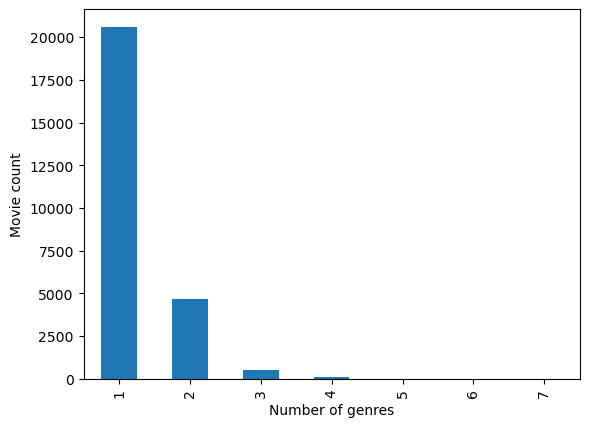

In [11]:
# Count of movies
print(multi_label.iloc[:,8:].sum(axis=1).value_counts())
multi_label.iloc[:,8:].sum(axis=1).value_counts().plot.bar(xlabel='Number of genres', ylabel='Movie count')

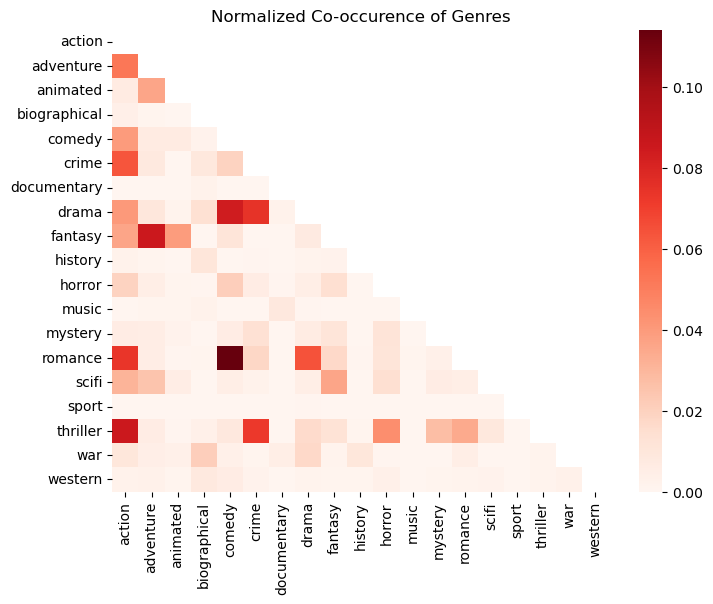

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the co-occurrence matrix
df = multi_label.iloc[:,8:]

co_occurrence_matrix = np.dot(df.T, df)

# Set the diagonal values to zero
np.fill_diagonal(co_occurrence_matrix, 0)

# Compute the counts of each genre
genre_counts = df.sum(axis=0).values

# Create a matrix of the maximum counts for normalization
max_counts_matrix = np.maximum.outer(genre_counts, genre_counts)

# Normalize the co-occurrence matrix by the maximum counts of each genre pair
normalized_co_occurrence_matrix = co_occurrence_matrix / max_counts_matrix

# Convert the matrix to a DataFrame
normalized_co_occurrence_df = pd.DataFrame(normalized_co_occurrence_matrix, index=df.columns, columns=df.columns)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_co_occurrence_df, annot=False, cmap='Reds', mask=np.triu(np.ones_like(normalized_co_occurrence_df)))
plt.title('Normalized Co-occurence of Genres')
plt.show()

# Single label dataset (multiclass)

In [13]:
single_label = wiki_movie_plots_processed[wiki_movie_plots_processed.iloc[:,8:].sum(axis=1)==1]
print(">> Number of movies with only 1 genre:", single_label.shape[0])
print('>> Number of raw rows:', wiki_movie_plots.shape[0])
print(single_label.shape[0]/wiki_movie_plots.shape[0])

>> Number of movies with only 1 genre: 20602
>> Number of raw rows: 34886
0.5905520839305165


<Axes: ylabel='Movie count'>

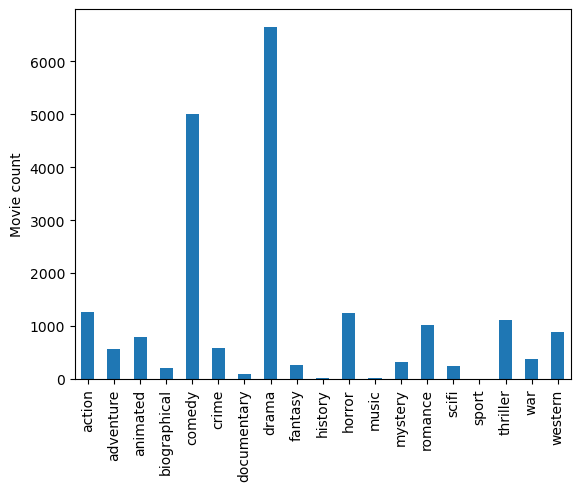

In [14]:
single_label.iloc[:,8:].sum(axis=0).plot.bar(ylabel='Movie count')

# Save datasets

In [15]:
# TBD

# Preprocessing plot

In [16]:
# # Install new libraries to handle contractions & spell checking
# !pip install contractions textsearch unidecode

In [17]:
import pandas as pd
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import string
from unidecode import unidecode

# Ensure required NLTK data files are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Initialize the lemmatizer and spell checker
lemmatizer = WordNetLemmatizer()

# Load stopwords and add punctuation to be removed
stop_words = set(stopwords.words('english'))
punctuation_table = str.maketrans('', '', string.punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Diamo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

In [18]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if POS tag is not recognized

def process_hyphens(token_list):
    '''
    Process a list of tokens, handling hyphens as specified:
    For tokens containing exactly one hyphen, the hyphen is removed: sci-fi -> scifi; hi-jacked -> hijacked
    For tokens containing more than one hyphen, the token is split into smaller tokens at each hyphen.
    bag-of-words -> [bag,of,words]
    Tokens with no hyphens are left unchanged.
    '''
    processed_tokens = []
    for token in token_list:
        hyphen_count = token.count('-')
        if hyphen_count == 1:
            # Replace the single hyphen with an empty string
            processed_tokens.append(token.replace('-', ''))
        elif hyphen_count > 1:
            # Split the token into smaller tokens separated by hyphen
            processed_tokens.extend(token.split('-'))
        else:
            # No hyphen in the token, keep it as it is
            processed_tokens.append(token)
    return processed_tokens

def preprocess_plot(plot, handle_hyphen=True, handle_name=True):
    """
    Preprocesses a plot description by expanding contractions, normalizing Unicode characters,
    replacing standalone hyphens with spaces, tokenizing while keeping hyphenated words, 
    lowercasing, removing stopwords, correcting spelling, lemmatizing with POS tags, 
    and removing hyphens within words.
    
    Parameters:
        plot (str): The plot description to preprocess.
        
    Returns:
        str: The preprocessed plot description.
    """
    if isinstance(plot, float):
        # Handle NaN or non-string plot descriptions
        return ""
    

    try:
        # Convert Unicode chars
        plot = unidecode(plot)   
        # Expand contractions
        plot = contractions.fix(plot)
    
        # Replace standalone hyphens with spaces
        if handle_hyphen:
            plot = re.sub(r'(?<=\s)-(?=\s)', ' ', plot)
        
        # Tokenize the plot while keeping hyphenated words
        tokens = word_tokenize(plot)
        
        # Get POS tags
        pos_tags = nltk.pos_tag(tokens)
        
        # Identify named entities (proper nouns) and replace person's names with a placeholder
        if handle_name:
            named_entities = nltk.ne_chunk(pos_tags)
            for chunk in named_entities:
                if hasattr(chunk, 'label') and chunk.label() == 'PERSON':
                    for c in chunk:
                        tokens = [token if token != c[0] else 'charname' for token in tokens]
    
        # Process hyphenations
        if handle_hyphen:
            tokens = process_hyphens(tokens)
        
        # Process tokens: lowercase, remove punctuation, remove stopwords, and lemmatize with POS tags, remove numbers
        processed_tokens = [
            # https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/
            lemmatizer.lemmatize(word.lower().translate(punctuation_table), get_wordnet_pos(tag))
            for word, tag in nltk.pos_tag(tokens)
            if word.isalpha() and word.lower() not in stop_words
        ]
        
        # Join tokens back into a single string
        processed_plot = ' '.join(processed_tokens)
    
        return processed_plot
        
    except:
        return 'PROCESSING_ERROR'

# Notes to preprocessing plots

## Unicode characters
`multi_label['Plot'].iloc[0]`: `As the train stops it is boarded by the bandits\u200d—\u200cnow four. Two bandits enter an express car, kill a messenger and open a box of valuables with dynamite; the others kill the fireman and force the engineer to halt the train and disconnect the locomotive.`

-> Need to decode Unicode characters like `\u200d`; otherwise the words `bandits` and `now` will be discarded unreasonably

## Hyphenated words
`multi_label['Plot'].iloc[2]`: `and later by a hi-jacked horse and cart.`

-> Don't want to tokenize `hi-jacked` -> `hi`, `jacked`; but into `hijacked`
But `bag-of-words` should be `bag`, `of`, `words`

## Person's names (character's names)
Use `nltk.ne_chunk` to replace it with a `charname` string. Can try to remove this preprocessing step (optional) to see if it improves the models

In [19]:
# Unicode character
example = multi_label[multi_label['Plot'].str.contains('The grandmother of rude big man ')]['Plot'].iloc[0]

print('>> Raw\n'+'-'*25)
display(example)

print('\n>> Processed\n'+'-'*25)
display(preprocess_plot(example, False, False))

>> Raw
-------------------------


'The grandmother of rude big man Recep İvedik (Şahan Gökbakar) wants him to find a job. He tries many, but is always fired soon. Finally he gets a job as "half-boss" in the company led by his cousin, after he points out that they inherited this company together from their grandfather. When Japanese business relations, to his cousin\'s regret, refuse to sign a contract, İvedik happens to wear a jacket of some organisation the Japanese are a member of, which makes them think he is the boss of that organisation; this and İvedik\'s pressure on them convinces them to sign the contract after all. This makes his cousin very satisfied about him.\r\nİvedik\'s grandmother also wants him to get married. He tries to find a woman with the assistance of a young worker of the company, Ali Kerem (Çagri Büyüksayar). They do not succeed, but Kerem helps İvedik by disguising as a woman and accompanying him to his grandmother, where they pretend they are in love.\r\nİvedik\'s grandmother dies. He inherits


>> Processed
-------------------------


'grandmother rude big man recep ivedik sahan gokbakar want find job try many always fire soon finally get job company lead cousin point inherit company together grandfather japanese business relation cousin regret refuse sign contract ivedik happen wear jacket organisation japanese member make think bos organisation ivedik pressure convince sign contract make cousin satisfied ivedik grandmother also want get married try find woman assistance young worker company ali kerem cagri buyuksayar succeed kerem help ivedik disguise woman accompany grandmother pretend love ivedik grandmother die inherit chest contain photograph make'

In [20]:
# Hyphenated words
i = 2

print('>> Raw\n'+'-'*25)
display(multi_label['Plot'].iloc[i])

print('\n>> Without handling hyphen\n'+'-'*25)
display(preprocess_plot(multi_label['Plot'].iloc[i], handle_hyphen=False))

print('\n>> Processed\n'+'-'*25)
display(preprocess_plot(multi_label['Plot'].iloc[i]))

>> Raw
-------------------------


'The film features a train traveling through the Rockies and a hold up created by two thugs placing logs on the line. They systematically rob the wealthy occupants at gunpoint and then make their getaway along the tracks and later by a hi-jacked horse and cart.'


>> Without handling hyphen
-------------------------


'film feature train travel rockies hold create two thug place log line systematically rob wealthy occupant gunpoint make getaway along track later horse cart'


>> Processed
-------------------------


'film feature train travel rockies hold create two thug place log line systematically rob wealthy occupant gunpoint make getaway along track later hijacked horse cart'

In [21]:
# Character Name
i = 3

print('>> Raw\n'+'-'*25)
display(multi_label['Plot'].iloc[i])

print('\n>> Without character name\n'+'-'*25)
display(preprocess_plot(multi_label['Plot'].iloc[i], handle_name=False))

print('\n>> Processed\n'+'-'*25)
display(preprocess_plot(multi_label['Plot'].iloc[i]))

>> Raw
-------------------------


"Boone's daughter befriends an Indian maiden as Boone and his companion start out on a hunting expedition. While he is away, Boone's cabin is attacked by the Indians, who set it on fire and abduct Boone's daughter. Boone returns, swears vengeance, then heads out on the trail to the Indian camp. His daughter escapes but is chased. The Indians encounter Boone, which sets off a huge fight on the edge of a cliff. A burning arrow gets shot into the Indian camp. Boone gets tied to the stake and tortured. The burning arrow sets the Indian camp on fire, causing panic. Boone is rescued by his horse, and Boone has a knife fight in which he kills the Indian chief.[2]"


>> Without character name
-------------------------


'boone daughter befriend indian maiden boone companion start hunting expedition away boone cabin attack indian set fire abduct boone daughter boone return swears vengeance head trail indian camp daughter escape chase indian encounter boone set huge fight edge cliff burning arrow get shoot indian camp boone get tie stake torture burn arrow set indian camp fire cause panic boone rescue horse boone knife fight kill indian chief'


>> Processed
-------------------------


'charname daughter befriend indian maiden charname companion start hunting expedition away charname cabin attack indian set fire abduct charname daughter charname return swears vengeance head trail indian camp daughter escape chase indian encounter charname set huge fight edge cliff burning arrow get shoot indian camp charname get tie stake torture burn arrow set indian camp fire cause panic charname rescue horse charname knife fight kill indian chief'

# Apply plot processing to full datasets

In [22]:
from concurrent.futures import ThreadPoolExecutor
# Parallelize the preprocessing of a DataFrame column so that it's faster
def parallel_preprocess(df, column_name, num_threads=4):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        processed_plots = list(executor.map(preprocess_plot, df[column_name]))
    df['Processed_Plot'] = processed_plots
    return df

In [23]:
import os
# Take a veryyyyyyyyyyyyyyyyyyyyyy long time, so load the pre-cleaned if exists and skip this part
if 'cleaned_data_.csv' in os.listdir(): # cleaned_data_.csv has some original columns dropped to reduce file size
    multi_label_processed = pd.read_csv('cleaned_data_.csv')
else:
    multi_label_processed = parallel_preprocess(multi_label, 'Plot', num_threads=8)
    # Save (remember to rename)
    multi_label_processed.to_csv('cleaned_data.csv', index=False)

# TFIDF (Single / Multiclass)

In [25]:
GENRE_COLUMNS = ['action', 'adventure',
       'animated', 'biographical', 'comedy', 'crime', 'documentary', 'drama',
       'fantasy', 'history', 'horror', 'music', 'mystery', 'romance', 'scifi',
       'sport', 'thriller', 'war', 'western']

In [26]:
single_label_processed = multi_label_processed[multi_label_processed[GENRE_COLUMNS].sum(axis=1)==1]
y_single = single_label_processed[GENRE_COLUMNS].idxmax(axis=1)
y_single

0             western
1              comedy
3        biographical
4              comedy
5              comedy
             ...     
25956           drama
25957           drama
25958          comedy
25959          comedy
25961         romance
Length: 20602, dtype: object

In [27]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)#, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(single_label_processed['Processed_Plot'])
X_single = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_single, y_single, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test)
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

      action       0.60      0.14      0.23       244
   adventure       0.62      0.04      0.08       112
    animated       0.95      0.23      0.37       179
biographical       0.00      0.00      0.00        38
      comedy       0.57      0.56      0.57       992
       crime       0.00      0.00      0.00       109
 documentary       0.00      0.00      0.00        17
       drama       0.43      0.89      0.59      1349
     fantasy       0.00      0.00      0.00        48
     history       0.00      0.00      0.00         2
      horror       0.72      0.51      0.60       253
     mystery       0.00      0.00      0.00        59
     romance       0.00      0.00      0.00       198
       scifi       1.00      0.02      0.04        48
    thriller       0.67      0.01      0.02       228
         war       0.69      0.11      0.19        84
     western       0.93      0.40      0.56       161

    accuracy              

## Key Observations
- Imbalanced Performance: The model performs significantly better on some genres (e.g., "drama," "comedy," "western") compared to others (e.g., "biographical," "crime," "documentary").
- Data Imbalance: Genres with more instances in the dataset (e.g., "drama," "comedy") tend to have better performance, suggesting data imbalance might be affecting the model.
- Low Precision and Recall for Many Labels: Many genres have both low precision and recall, indicating that the model is neither good at correctly identifying these genres nor avoiding false positives.

# TFIDF (Multi)

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)#, ngram_range=(1))
tfidf_matrix = tfidf_vectorizer.fit_transform(multi_label_processed['Processed_Plot'])
X_train = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [31]:
X_train.shape

(25962, 5000)

In [32]:
X_train

,abandon,abandoned,abduct,ability,able,aboard,abort,abortion,abroad,abruptly,...,york,youboat,young,younger,youngster,youth,zamindar,zombie,zone,zoo
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.108804,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25957,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25958,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25959,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25960,0.0,0.0,0.000000,0.0,0.073376,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.050944,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y_train = multi_label_processed[GENRE_COLUMNS]

In [34]:
y_train

,action,adventure,animated,biographical,comedy,crime,documentary,drama,fantasy,history,horror,music,mystery,romance,scifi,sport,thriller,war,western
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25957,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
25958,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25959,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25960,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Multi-label NB

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
clf = MultiOutputClassifier(MultinomialNB())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [36]:
report = classification_report(y_test, y_pred, target_names=y_train.columns, zero_division=0)
print(report)

              precision    recall  f1-score   support

      action       0.82      0.03      0.06       485
   adventure       0.00      0.00      0.00       177
    animated       1.00      0.09      0.16       203
biographical       0.00      0.00      0.00        71
      comedy       0.78      0.18      0.29      1482
       crime       0.00      0.00      0.00       313
 documentary       0.00      0.00      0.00        26
       drama       0.68      0.36      0.47      1841
     fantasy       0.00      0.00      0.00       122
     history       0.00      0.00      0.00         2
      horror       0.77      0.16      0.26       342
       music       0.00      0.00      0.00         4
     mystery       0.00      0.00      0.00        85
     romance       0.67      0.01      0.02       537
       scifi       1.00      0.01      0.03        79
       sport       0.00      0.00      0.00         1
    thriller       0.00      0.00      0.00       366
         war       0.83    

## Genre-specific

- The highest precision scores are for "animated" (1.00) and "scifi" (1.00), suggesting that when the model predicts these labels, it is often correct.
- Other genres like "comedy" (0.78) and "drama" (0.68) have moderately high precision, while many others, including "adventure," "biographical," and "crime," have precision scores of 0.00, indicating the model struggles to correctly identify these genres.
- The highest recall scores are for "drama" (0.36) and "comedy" (0.18), suggesting the model is relatively better at identifying these genres compared to others.
- Many genres, such as "adventure," "biographical," "crime," and "documentary," have recall scores of 0.00, indicating the model fails to identify any true instances of these genres.

## Support

This is the number of actual occurrences of each label in the test set.

- Genres like "drama" (1841), "comedy" (1482), and "action" (485) have high support, meaning there are many instances of these labels in the test set.
- Genres with low support, such as "documentary" (26) and "history" (2), may suffer from the model's inability to generalize well due to the limited number of instances.


## Overall

- The Naive Bayes model performs well for certain genres like "drama" and "comedy" but poorly for many others, especially those with low support or more specific labels.
- There is a significant imbalance between precision and recall, with precision generally higher. This indicates the model makes fewer false positives but misses many true positives.
- The overall performance, as indicated by the low macro and weighted F1-scores, suggests that the model struggles with multi-label classification in this context.